## <b>Surgical Tools Classification 

that data get from : https://www.kaggle.com/datasets/dilavado/labeled-surgical-tools

In total it contains 3009 images and the respective labels classifying the objects as Scalpel, Straight Dissection Clamp, Straight Mayo Scissor or Curved Mayo Scissor

in this dataset contain labeled data which use for train and predict bounding box for Image Detection

<b>But in this work I just use Alone image in each class for classification only , It's mean just use only 2010 image for train/val/test for classification by ratio 0.7/0.1/0.2

### Import

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import shutil
# shutil.copy("/content/drive/MyDrive/dataset/Surgical_tools/Surgical_tools.zip", "/content/Surgical_tools.zip")

In [3]:
# !unzip Surgical_tools.zip

In [4]:
import tensorflow as tf
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.is_gpu_available():
    print("GPU is available")
else:
    print("GPU is not available")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


In [5]:
from sklearn.metrics import classification_report , confusion_matrix
from numpy import argmax , where
import math
from matplotlib import pyplot as plt
import cv2 
from keras.optimizers import Adam
import os
import shutil
import random
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers

### Data in Class 

In [6]:
base_dir = 'C:\\Users\\gmita\\Desktop\\work_3_2_2565\\onboard\\Surgical-Dataset\\Images\\'
class_names = ["Curved Mayo Scissor","Scalpel","Straight Dissection Clamp","Straight Mayo Scissor"]

This dataset contain 4 classed : [Curved Mayo Scissor , Scalpel , Straight Dissection Clamp , Straight Mayo Scissor]

Display some data in each class


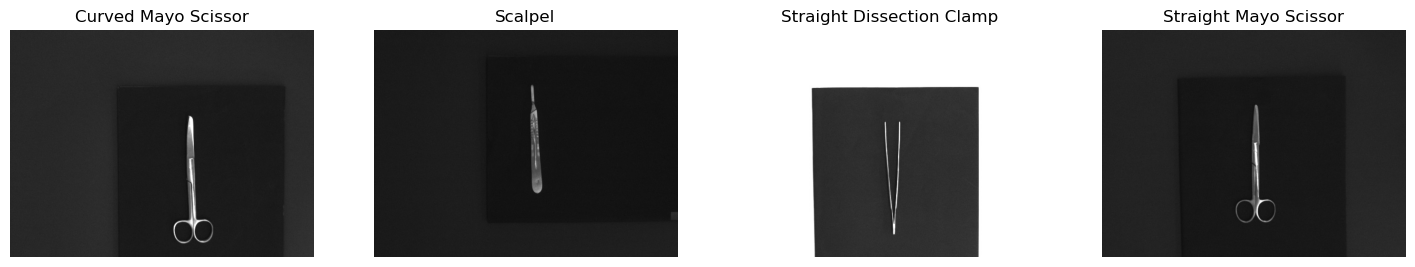

In [7]:

fig = plt.figure(figsize=(1,4))
fig.set_figwidth(18)
fig.set_figheight(8)
for row,i in enumerate(class_names) :
    path = base_dir + i + "/Alone"
    List_img = sorted(os.listdir(path))
    img = cv2.imread(os.path.join(path, List_img[0]))
    fig.add_subplot(1, 4, row + 1) 
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{i}")


### Setup directory of Data for Train Val Test 

split to 70 10 20 train val test

In [8]:
# set up to this 
# | --- COMBINE
# |     | --- train
# |     |     | --- Curved Mayo Scissor
# |     |     | --- | --- img 1...
# |     |     | --- | --- img 2...
# |     |     | --- | --- ...
# |     |     | --- Scalpel
# |     |     | --- Straight Dissection Clamp
# |     |     | --- Straight Mayo Scissor
# |     | --- val
# |     |     | --- Curved Mayo Scissor
# |     |     | --- Scalpel
# |     |     | --- Straight Dissection Clamp
# |     |     | --- Straight Mayo Scissor
# |     | --- test
# |     |     | --- Curved Mayo Scissor
# |     |     | --- Scalpel
# |     |     | --- Straight Dissection Clamp
# |     |     | --- Straight Mayo Scissor


random.seed(999)


image_size = (224, 224)
# set up directories
combined_dir = os.path.join(base_dir, 'COMBINE')

combined_data = []
for class_name in class_names:
    class_directory = os.path.join(base_dir, class_name + "/Alone")
    file_names = os.listdir(class_directory)
    for file_name in file_names:
        combined_data.append((os.path.join(class_directory, file_name), class_name))

random.shuffle(combined_data)

# split data into train, validation, and test sets
split_ratio = [0.7, 0.1, 0.2] # 70% train, 10% val, 20% test
split_idx = [int(len(combined_data)*split_ratio[0]), int(len(combined_data)*(split_ratio[0]+split_ratio[1]))]
train_data = combined_data[:split_idx[0]]
val_data = combined_data[split_idx[0]:split_idx[1]]
test_data = combined_data[split_idx[1]:]

# save data to combined directory
for data, directory_type in [(train_data, 'train'), (val_data, 'val'), (test_data, 'test')]:
    for image_path, class_name in data:
        # read image and resize
        image = cv2.imread(image_path)
        image = cv2.resize(image, image_size) # change this to your desired size

        # save resized image to combined directory
        destination_directory = os.path.join(combined_dir, directory_type, class_name)
        if not os.path.exists(destination_directory):
            os.makedirs(destination_directory)
        file_name = os.path.basename(image_path)
        cv2.imwrite(os.path.join(destination_directory, file_name), image)

In [9]:
print("train")
a = []
for i in class_names :
    a.append(len(os.listdir("C:/Users/gmita/Desktop/work_3_2_2565/onboard//Surgical-Dataset\Images/COMBINE/train/" + i)))
print(a , sum(a))
a.clear()

print("val")
for i in class_names :
    a.append(len(os.listdir("C:/Users/gmita/Desktop/work_3_2_2565/onboard//Surgical-Dataset\Images/COMBINE/val/" + i)))
print(a,sum(a))
a.clear()

print("test")
for i in class_names :
    a.append(len(os.listdir("C:/Users/gmita/Desktop/work_3_2_2565/onboard//Surgical-Dataset\Images/COMBINE/test/" + i)))
print(a,sum(a))

train
[385, 384, 333, 305] 1407
val
[61, 55, 44, 40] 200
test
[104, 111, 83, 105] 403


### Train Val Test using ImageDataGenerator


just use only rescale

In [10]:
train_data = ImageDataGenerator(rescale=1./255)
val_data = ImageDataGenerator(rescale=1./255)
test_data = ImageDataGenerator(rescale=1./255)

In [11]:
batch_size = 16
train_gen = train_data.flow_from_directory("C:/Users/gmita/Desktop/work_3_2_2565/onboard//Surgical-Dataset\Images/COMBINE/train",
                                           target_size=image_size,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           color_mode="rgb",
                                           class_mode="categorical",
                                           classes=class_names)
val_gen = val_data.flow_from_directory("C:/Users/gmita/Desktop/work_3_2_2565/onboard//Surgical-Dataset\Images/COMBINE/val",
                                           target_size=image_size,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           color_mode="rgb",
                                           class_mode="categorical",
                                           classes=class_names)
test_gen = test_data.flow_from_directory("C:/Users/gmita/Desktop/work_3_2_2565/onboard//Surgical-Dataset\Images/COMBINE/test",
                                           target_size=image_size,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           color_mode="rgb",
                                           class_mode="categorical",
                                           classes=class_names)

Found 1407 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Found 403 images belonging to 4 classes.


In [12]:

STEP_SIZE_TRAIN = math.ceil(train_gen.n/train_gen.batch_size)
STEP_SIZE_VAL = math.ceil(val_gen.n/val_gen.batch_size)
STEP_SIZE_TEST = math.ceil(test_gen.n/test_gen.batch_size)

### CNN normal 

In [13]:
# Create Sequential Model
model0 = keras.Sequential()
# Layer 1: Convolutional Layer
model0.add(layers.Conv2D(filters=32, kernel_size=(5,5), input_shape=(224,224,3), activation='relu',))
# Layer 2: Pooling Layer
model0.add(layers.MaxPool2D(pool_size=(2,2)))
# Layer 3: Convolutional Layer
model0.add(layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu',))
# Layer 4: Pooling Layer
model0.add(layers.MaxPool2D(pool_size=(2,2)))
# Layer 5: Flatten Layer
model0.add(layers.Flatten())
# Layer 6: Dense Layer (Hidden Layer)
model0.add(layers.Dense(128, activation='relu'))
# Layer 7: Dense Layer (Output Layer)
model0.add(layers.Dense(4, activation='softmax'))
model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 32)      25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 89888)             0         
                                                                 
 dense (Dense)               (None, 128)               1

In [14]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

In [15]:
model0.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(learning_rate=0.001),metrics=["accuracy"])
history_model_cnn = model0.fit(train_gen ,steps_per_epoch=STEP_SIZE_TRAIN,validation_data=val_gen,validation_steps=STEP_SIZE_VAL,
                    epochs = 20 )

Epoch 1/20
88/88 [==============================] - 10s 87ms/step - loss: 0.8225 - accuracy: 0.6930 - val_loss: 0.5110 - val_accuracy: 0.7800
Epoch 2/20
88/88 [==============================] - 3s 29ms/step - loss: 0.3284 - accuracy: 0.8593 - val_loss: 0.3544 - val_accuracy: 0.8550
Epoch 3/20
88/88 [==============================] - 3s 31ms/step - loss: 0.2198 - accuracy: 0.9247 - val_loss: 0.3843 - val_accuracy: 0.8650
Epoch 4/20
88/88 [==============================] - 3s 30ms/step - loss: 0.2331 - accuracy: 0.9353 - val_loss: 0.3561 - val_accuracy: 0.9000
Epoch 5/20
88/88 [==============================] - 3s 29ms/step - loss: 0.1495 - accuracy: 0.9545 - val_loss: 0.4294 - val_accuracy: 0.8650
Epoch 6/20
88/88 [==============================] - 3s 32ms/step - loss: 0.1222 - accuracy: 0.9595 - val_loss: 0.4150 - val_accuracy: 0.8500
Epoch 7/20
88/88 [==============================] - 3s 29ms/step - loss: 0.1550 - accuracy: 0.9687 - val_loss: 0.5773 - val_accuracy: 0.8800
Epoch 8/20
8

In [16]:
scores0 = model0.evaluate(test_gen,steps=STEP_SIZE_TEST)

26/26 [==============================] - 2s 73ms/step - loss: 1.1627 - accuracy: 0.8660


In [17]:
p = model0.predict(test_gen,steps=STEP_SIZE_TEST)
p_class = argmax(p,axis=1)
print(classification_report(p_class ,test_gen.classes))

26/26 [==============================] - 1s 23ms/step
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        94
           1       0.91      0.89      0.90       114
           2       0.92      0.75      0.83       101
           3       0.83      0.93      0.87        94

    accuracy                           0.87       403
   macro avg       0.87      0.87      0.86       403
weighted avg       0.87      0.87      0.87       403



### VGG16 Model


In [18]:
input = keras.Input(shape= (224,224,3) )
vgg16_model = keras.applications.VGG16(weights=None, include_top=False ,input_tensor = input)

Add Flatten and add some FC and Last Output with 4 Class 

In [19]:
model1 = keras.models.Sequential()
model1.add(vgg16_model)
model1.add(keras.layers.Flatten())
model1.add(keras.layers.BatchNormalization())
model1.add(keras.layers.Dense(256, activation='relu'))
model1.add(keras.layers.BatchNormalization())
model1.add(keras.layers.Dense(128, activation='relu'))
model1.add(keras.layers.BatchNormalization())
model1.add(keras.layers.Dense(4, activation='softmax'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 128)              

In [20]:
model1.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),metrics=["accuracy"])
# callback = keras.callbacks.EarlyStopping(monitor="loss",patience=3)

In [21]:
history_model00 = model1.fit(train_gen ,steps_per_epoch=STEP_SIZE_TRAIN,validation_data=val_gen,validation_steps=STEP_SIZE_VAL,
                    epochs = 20 )
                    

Epoch 1/20
88/88 [==============================] - 30s 280ms/step - loss: 0.8709 - accuracy: 0.6795 - val_loss: 1.4071 - val_accuracy: 0.2750
Epoch 2/20
88/88 [==============================] - 20s 226ms/step - loss: 0.5929 - accuracy: 0.7932 - val_loss: 1.4538 - val_accuracy: 0.4400
Epoch 3/20
88/88 [==============================] - 20s 225ms/step - loss: 0.4965 - accuracy: 0.8159 - val_loss: 1.4205 - val_accuracy: 0.3550
Epoch 4/20
88/88 [==============================] - 20s 227ms/step - loss: 0.4528 - accuracy: 0.8301 - val_loss: 1.3872 - val_accuracy: 0.3900
Epoch 5/20
88/88 [==============================] - 20s 228ms/step - loss: 0.4067 - accuracy: 0.8557 - val_loss: 1.2856 - val_accuracy: 0.3700
Epoch 6/20
88/88 [==============================] - 20s 229ms/step - loss: 0.3595 - accuracy: 0.8763 - val_loss: 0.9235 - val_accuracy: 0.6450
Epoch 7/20
88/88 [==============================] - 20s 227ms/step - loss: 0.2996 - accuracy: 0.8898 - val_loss: 0.6988 - val_accuracy: 0.7300

In [22]:
scores1 = model1.evaluate(test_gen,steps=STEP_SIZE_TEST)

26/26 [==============================] - 2s 94ms/step - loss: 0.2660 - accuracy: 0.9057


In [23]:
p = model1.predict(test_gen,steps=STEP_SIZE_TEST)
p_class = argmax(p,axis=1)


26/26 [==============================] - 2s 58ms/step


In [24]:
print(classification_report(p_class ,test_gen.classes))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       100
           1       0.98      0.86      0.92       127
           2       0.90      0.96      0.93        78
           3       0.88      0.94      0.91        98

    accuracy                           0.91       403
   macro avg       0.90      0.91      0.91       403
weighted avg       0.91      0.91      0.91       403



### VGG16 Model with pretrain weight 

weight from dataset "imagenet"

In [25]:
input = keras.Input(shape= (224,224,3) )
vgg16_model = keras.applications.VGG16(weights="imagenet", include_top=False ,input_tensor = input)

Freeze all VGG16layer

In [26]:
for layer in vgg16_model.layers[:20]:
    layer.trainable = False

Add Flatten and add some FC and Last Output with 4 Class 

In [27]:
model2 = keras.models.Sequential()
model2.add(vgg16_model)
model2.add(keras.layers.Flatten())
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Dense(256, activation='relu'))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Dense(128, activation='relu'))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Dense(4, activation='softmax'))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_3 (Batc  (None, 25088)            100352    
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 256)               6422784   
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 128)              

In [28]:
model2.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),metrics=["accuracy"])
# callback = keras.callbacks.EarlyStopping(monitor="loss",patience=3)

In [29]:
history_model0 = model2.fit(train_gen ,steps_per_epoch=STEP_SIZE_TRAIN,validation_data=val_gen,validation_steps=STEP_SIZE_VAL,
                    epochs = 20)
                    

Epoch 1/20
88/88 [==============================] - 9s 87ms/step - loss: 0.6580 - accuracy: 0.7505 - val_loss: 1.0044 - val_accuracy: 0.6350
Epoch 2/20
88/88 [==============================] - 8s 88ms/step - loss: 0.2350 - accuracy: 0.9325 - val_loss: 0.6457 - val_accuracy: 0.8650
Epoch 3/20
88/88 [==============================] - 7s 83ms/step - loss: 0.1505 - accuracy: 0.9538 - val_loss: 0.3349 - val_accuracy: 0.9200
Epoch 4/20
88/88 [==============================] - 7s 81ms/step - loss: 0.0927 - accuracy: 0.9815 - val_loss: 0.2601 - val_accuracy: 0.9250
Epoch 5/20
88/88 [==============================] - 7s 82ms/step - loss: 0.0777 - accuracy: 0.9794 - val_loss: 0.1888 - val_accuracy: 0.9400
Epoch 6/20
88/88 [==============================] - 7s 82ms/step - loss: 0.0764 - accuracy: 0.9794 - val_loss: 0.1698 - val_accuracy: 0.9500
Epoch 7/20
88/88 [==============================] - 7s 82ms/step - loss: 0.0557 - accuracy: 0.9872 - val_loss: 0.1640 - val_accuracy: 0.9450
Epoch 8/20
88

In [30]:
scores2 = model2.evaluate(test_gen,steps=STEP_SIZE_TEST)

26/26 [==============================] - 2s 69ms/step - loss: 0.1656 - accuracy: 0.9479


In [31]:
p = model2.predict(test_gen,steps=STEP_SIZE_TEST)
p_class = argmax(p,axis=1)


26/26 [==============================] - 2s 67ms/step


In [32]:
print(classification_report(p_class ,test_gen.classes))

              precision    recall  f1-score   support

           0       0.96      0.89      0.93       112
           1       0.98      0.97      0.98       112
           2       0.96      0.98      0.97        82
           3       0.89      0.96      0.92        97

    accuracy                           0.95       403
   macro avg       0.95      0.95      0.95       403
weighted avg       0.95      0.95      0.95       403



Plot Loss vs Val_loss and Acc vs Val_acc

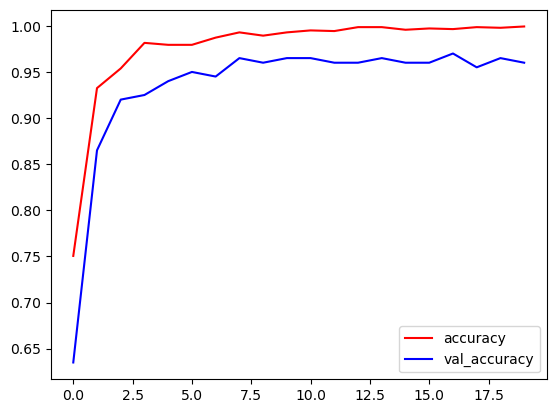

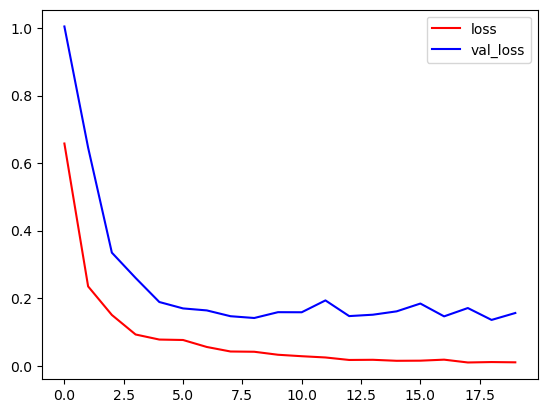

In [33]:


accuracy = history_model0.history["accuracy"]
val_accuracy = history_model0.history["val_accuracy"]

loss = history_model0.history["loss"]
val_loss = history_model0.history["val_loss"]

epochs = range(len(accuracy))


plt.figure(211)
plt.plot(epochs,accuracy , "r", label="accuracy")
plt.plot(epochs,val_accuracy , "b", label="val_accuracy")
plt.legend(loc='lower right')
plt.figure(212)
plt.plot(epochs,loss , "r", label="loss")
plt.plot(epochs,val_loss , "b", label="val_loss")
plt.legend(loc='upper right')



[ 16  18  24  27 155 156 217 225 226 299 300 303 305 307 317 362 364 371
 374 383 397]


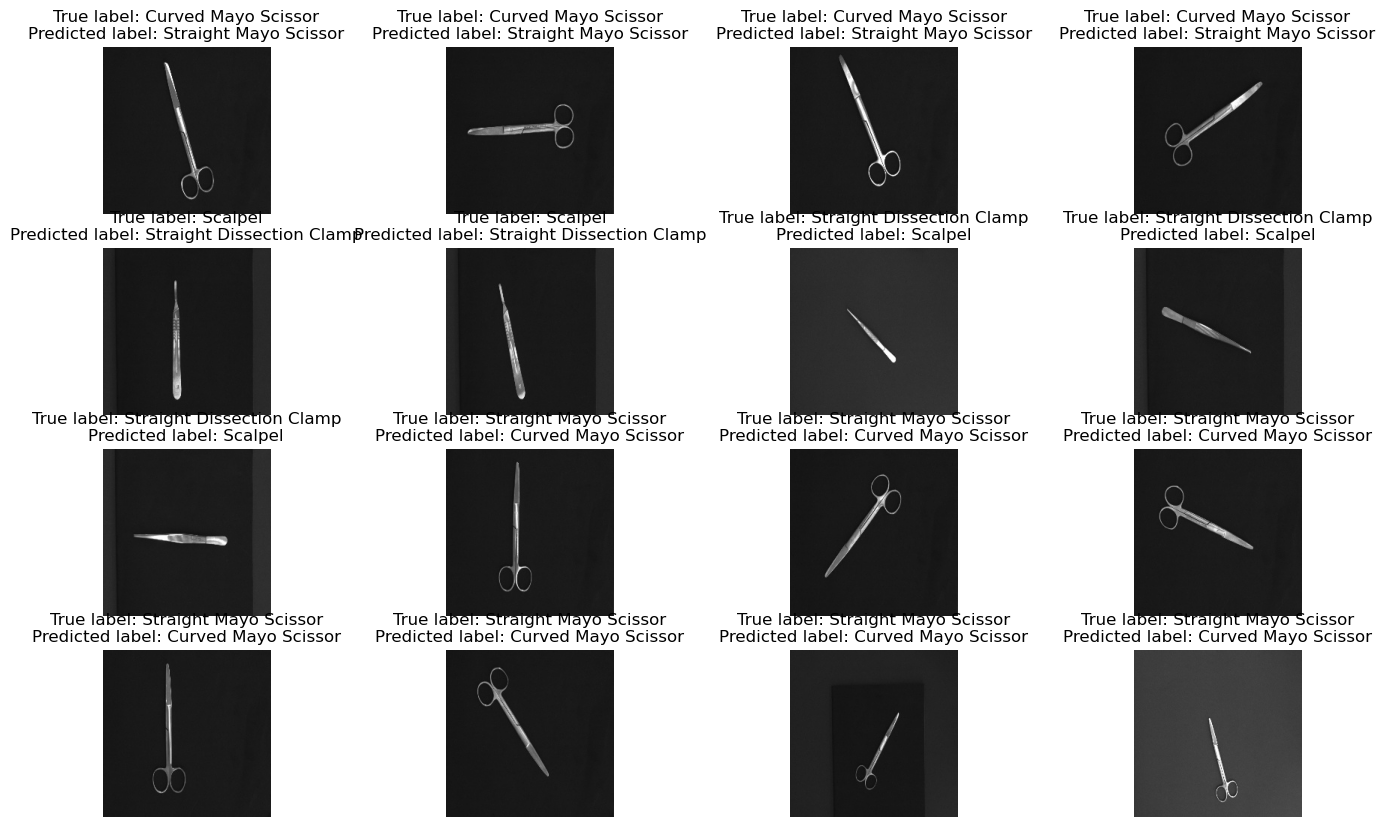

In [34]:
# Get the true labels
true_labels = test_gen.classes

test_dir = base_dir + "\\COMBINE\\test"
# Get the filenames of the test images
filenames = test_gen.filenames

# Find the indices of the images with wrong predictions
wrong_indices = where(true_labels != p_class)[0]

print(wrong_indices)

size = (4,4)
fig = plt.figure(figsize=size)
fig.set_figwidth(17)
fig.set_figheight(10)
# Show the images with wrong predictions
for count,i in enumerate(wrong_indices):
    img = cv2.imread(os.path.join(test_dir, filenames[i]))
    fig.add_subplot(size[0], size[1], count + 1) 
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True label: {class_names[true_labels[i]]}" + "\n"  + f"Predicted label: {class_names[p_class[i]]}")
    if count + 1 == size[0]*size[1] :
        break

1.	The mispredictions mostly belong to the each class of mayo scissors, both of them, because they have similar characteristics.
2.	The predictions between clamps and scalpels are swapped, because the clamp flipped   makes it similar to a scalpel.


### ResNet50 Model


In [39]:
input = keras.Input(shape= (224,224,3) )
resnet50 = keras.applications.ResNet50(weights=None, include_top=False ,input_tensor = input)

Add Flatten and add some FC and Last Output with 4 Class 

In [41]:
resnet50_model0 = keras.models.Sequential()
resnet50_model0.add(resnet50)
resnet50_model0.add(keras.layers.Flatten())
resnet50_model0.add(keras.layers.BatchNormalization())
resnet50_model0.add(keras.layers.Dense(256, activation='relu'))
resnet50_model0.add(keras.layers.BatchNormalization())
resnet50_model0.add(keras.layers.Dense(128, activation='relu'))
resnet50_model0.add(keras.layers.BatchNormalization())
resnet50_model0.add(keras.layers.Dense(4, activation='softmax'))
resnet50_model0.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization_6 (Batc  (None, 100352)           401408    
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 256)               25690368  
                                                                 
 batch_normalization_7 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 128)              

In [42]:
resnet50_model0.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),metrics=["accuracy"])
# callback = keras.callbacks.EarlyStopping(monitor="loss",patience=3)

In [43]:
history_model10 = resnet50_model0.fit(train_gen ,steps_per_epoch=STEP_SIZE_TRAIN,validation_data=val_gen,validation_steps=STEP_SIZE_VAL,
                    epochs = 20 )
                    

Epoch 1/20
88/88 [==============================] - 41s 325ms/step - loss: 0.9845 - accuracy: 0.6205 - val_loss: 1.5719 - val_accuracy: 0.2750
Epoch 2/20
88/88 [==============================] - 24s 276ms/step - loss: 0.5938 - accuracy: 0.7825 - val_loss: 1.8876 - val_accuracy: 0.2750
Epoch 3/20
88/88 [==============================] - 24s 276ms/step - loss: 0.4374 - accuracy: 0.8401 - val_loss: 2.2244 - val_accuracy: 0.2700
Epoch 4/20
88/88 [==============================] - 24s 277ms/step - loss: 0.3913 - accuracy: 0.8628 - val_loss: 1.7306 - val_accuracy: 0.3750
Epoch 5/20
88/88 [==============================] - 24s 277ms/step - loss: 0.3398 - accuracy: 0.8806 - val_loss: 1.9655 - val_accuracy: 0.3600
Epoch 6/20
88/88 [==============================] - 25s 279ms/step - loss: 0.2976 - accuracy: 0.8905 - val_loss: 1.6570 - val_accuracy: 0.3050
Epoch 7/20
88/88 [==============================] - 25s 278ms/step - loss: 0.3031 - accuracy: 0.8898 - val_loss: 1.5230 - val_accuracy: 0.3550

In [44]:
scores6 = resnet50_model0.evaluate(test_gen,steps=STEP_SIZE_TEST)

26/26 [==============================] - 2s 85ms/step - loss: 0.2786 - accuracy: 0.9007


In [45]:
p = resnet50_model0.predict(test_gen,steps=STEP_SIZE_TEST)
p_class = argmax(p,axis=1)


26/26 [==============================] - 3s 64ms/step


In [46]:
print(classification_report(p_class ,test_gen.classes))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88        92
           1       0.94      0.90      0.92       115
           2       0.93      0.88      0.90        88
           3       0.91      0.89      0.90       108

    accuracy                           0.90       403
   macro avg       0.90      0.90      0.90       403
weighted avg       0.90      0.90      0.90       403



### ResNet50 Model with pretrain weight 

weight from dataset "imagenet"

In [47]:


input = keras.Input(shape= (224,224,3) )
res_model = keras.applications.ResNet50(weights= "imagenet", include_top=False ,input_tensor = input)
for layer in res_model.layers:
    layer.trainable = False

In [48]:
resnet50_model = keras.models.Sequential()
resnet50_model.add(res_model)
resnet50_model.add(keras.layers.Flatten())
resnet50_model.add(keras.layers.BatchNormalization())
resnet50_model.add(keras.layers.Dense(256, activation='relu'))
resnet50_model.add(keras.layers.BatchNormalization())
resnet50_model.add(keras.layers.Dense(128, activation='relu'))
resnet50_model.add(keras.layers.BatchNormalization())
resnet50_model.add(keras.layers.Dense(4, activation='softmax'))
resnet50_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization_9 (Batc  (None, 100352)           401408    
 hNormalization)                                                 
                                                                 
 dense_11 (Dense)            (None, 256)               25690368  
                                                                 
 batch_normalization_10 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 128)              

In [49]:
resnet50_model.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),metrics=["accuracy"])
callback = keras.callbacks.EarlyStopping(monitor="val_loss",patience=10)

In [50]:
history_model1 = resnet50_model.fit(train_gen ,steps_per_epoch=STEP_SIZE_TRAIN,validation_data=val_gen,validation_steps=STEP_SIZE_VAL,
                    epochs = 20)

Epoch 1/20
88/88 [==============================] - 14s 106ms/step - loss: 0.7410 - accuracy: 0.7207 - val_loss: 1.4667 - val_accuracy: 0.2650
Epoch 2/20
88/88 [==============================] - 8s 89ms/step - loss: 0.4105 - accuracy: 0.8486 - val_loss: 0.9716 - val_accuracy: 0.6250
Epoch 3/20
88/88 [==============================] - 8s 90ms/step - loss: 0.3317 - accuracy: 0.8813 - val_loss: 0.5461 - val_accuracy: 0.8050
Epoch 4/20
88/88 [==============================] - 8s 89ms/step - loss: 0.2615 - accuracy: 0.9104 - val_loss: 0.3883 - val_accuracy: 0.8650
Epoch 5/20
88/88 [==============================] - 8s 90ms/step - loss: 0.2280 - accuracy: 0.9311 - val_loss: 0.3049 - val_accuracy: 0.8750
Epoch 6/20
88/88 [==============================] - 8s 89ms/step - loss: 0.1899 - accuracy: 0.9353 - val_loss: 0.3230 - val_accuracy: 0.8750
Epoch 7/20
88/88 [==============================] - 8s 90ms/step - loss: 0.1757 - accuracy: 0.9439 - val_loss: 0.2972 - val_accuracy: 0.9150
Epoch 8/20


In [51]:
scores3 = resnet50_model.evaluate(test_gen,steps=STEP_SIZE_TEST)

26/26 [==============================] - 2s 68ms/step - loss: 0.2680 - accuracy: 0.9132


In [52]:
p = resnet50_model.predict(test_gen,steps=STEP_SIZE_TEST)
p_class = argmax(p,axis=1)
print(classification_report(p_class ,test_gen.classes))

26/26 [==============================] - 3s 65ms/step
              precision    recall  f1-score   support

           0       0.82      0.98      0.89        87
           1       0.96      0.86      0.91       124
           2       0.90      0.94      0.92        80
           3       0.96      0.90      0.93       112

    accuracy                           0.91       403
   macro avg       0.91      0.92      0.91       403
weighted avg       0.92      0.91      0.91       403



Plot loss and acc

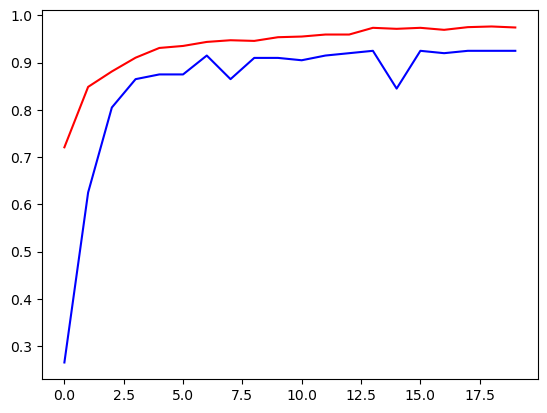

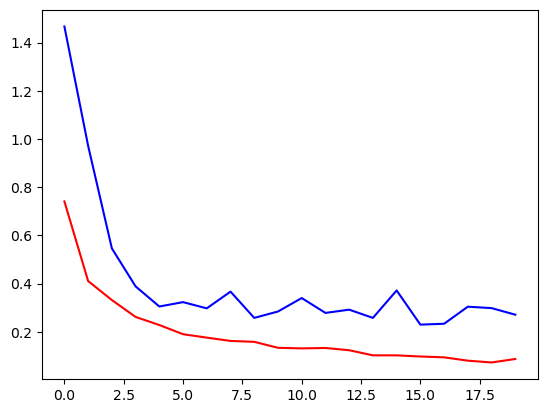

In [53]:

accuracy = history_model1.history["accuracy"]
val_accuracy = history_model1.history["val_accuracy"]

loss = history_model1.history["loss"]
val_loss = history_model1.history["val_loss"]

epochs = range(len(accuracy))


plt.figure(211)
plt.plot(epochs,accuracy , "r", label="accuracy")
plt.plot(epochs,val_accuracy , "b", label="val_accuracy")
plt.figure(212)
plt.plot(epochs,loss , "r", label="loss")
plt.plot(epochs,val_loss , "b", label="val_loss")

[  1   5   7  10  14  15  18  19  20  22  25  26  27  86  87  95  96  97
 103 155 156 160 187 217 221 222 226 232 288 293 294 352 364 391 397]


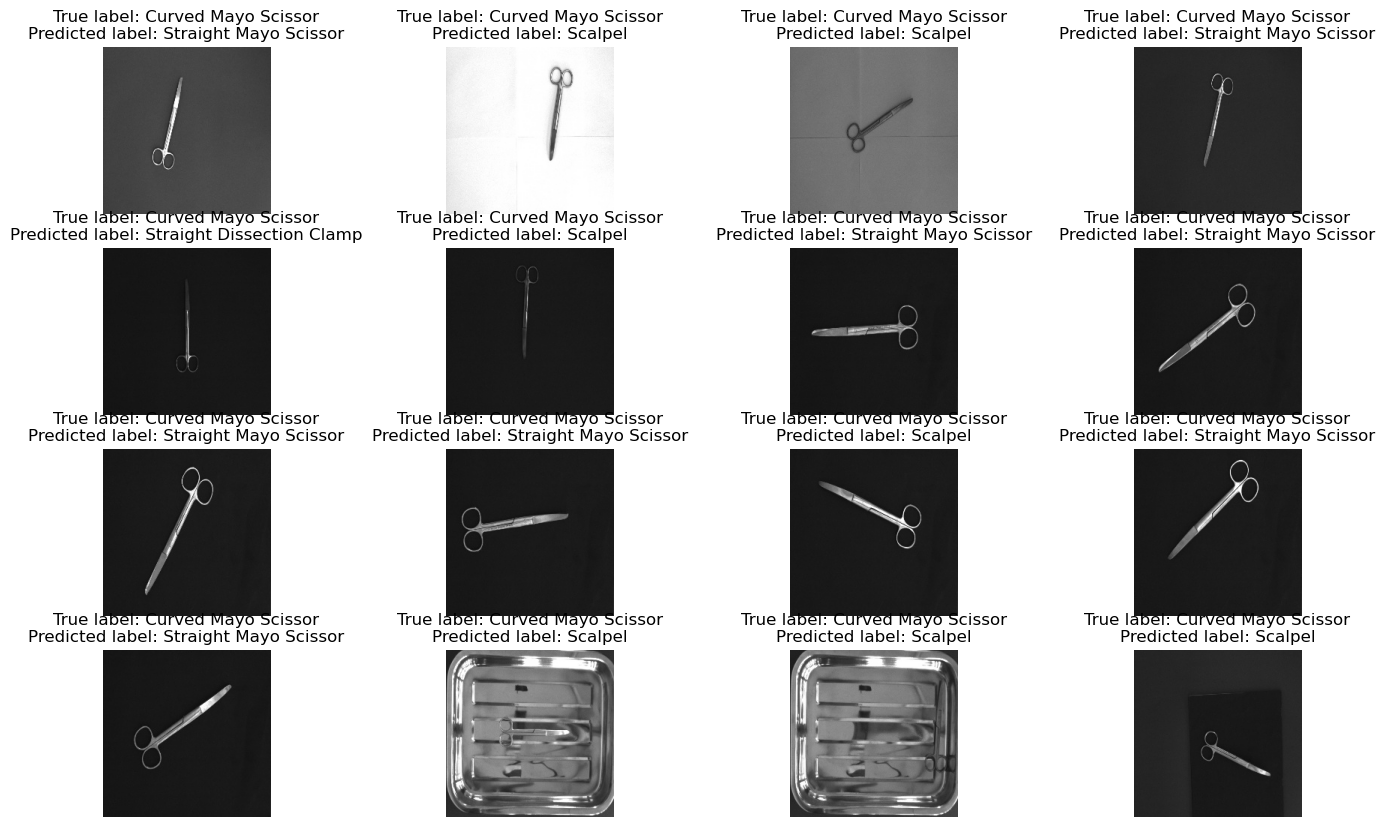

In [54]:

# Get the true labels
true_labels = test_gen.classes

test_dir = "C:\\Users\\gmita\\Desktop\\work_3_2_2565\\onboard\\Surgical-Dataset\\Images\\COMBINE\\test"
# Get the filenames of the test images
filenames = test_gen.filenames

# Find the indices of the images with wrong predictions
wrong_indices = where(true_labels != p_class)[0]

print(wrong_indices)

size = (4,4)
fig = plt.figure(figsize=size)
fig.set_figwidth(17)
fig.set_figheight(10)
# Show the images with wrong predictions
for count,i in enumerate(wrong_indices):
    img = cv2.imread(os.path.join(test_dir, filenames[i]))
    fig.add_subplot(size[0], size[1], count + 1) 
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True label: {class_names[true_labels[i]]}" + "\n"  + f"Predicted label: {class_names[p_class[i]]}")
    if count + 1 == size[0]*size[1] :
        break

### Save model

In [55]:
model0.save('C:\\Users\\gmita\\Desktop\\work_3_2_2565\\onboard\\Surgical-Dataset\\weight\\CNN.h5')
model1.save('C:\\Users\\gmita\\Desktop\\work_3_2_2565\\onboard\\Surgical-Dataset\\weight\\vgg16.h5')
model2.save('C:\\Users\\gmita\\Desktop\\work_3_2_2565\\onboard\\Surgical-Dataset\\weight\\vgg16_pre.h5')
resnet50_model0.save('C:\\Users\gmita\\Desktop\\work_3_2_2565\\onboard\\Surgical-Dataset\\weight\\res50.h5')
resnet50_model.save('C:\\Users\gmita\\Desktop\\work_3_2_2565\\onboard\\Surgical-Dataset\\weight\\res50_pre.h5')

### Compare

In [56]:
CNN = keras.models.load_model('C:\\Users\\gmita\\Desktop\\work_3_2_2565\\onboard\\Surgical-Dataset\\weight\\CNN.h5')
VGG16 = keras.models.load_model('C:\\Users\\gmita\\Desktop\\work_3_2_2565\\onboard\\Surgical-Dataset\\weight\\vgg16.h5')
VGG16_pre = keras.models.load_model('C:\\Users\\gmita\\Desktop\\work_3_2_2565\\onboard\\Surgical-Dataset\\weight\\vgg16_pre.h5')
RES50 = keras.models.load_model('C:\\Users\\gmita\\Desktop\\work_3_2_2565\\onboard\\Surgical-Dataset\\weight\\res50.h5')
RES50_pre = keras.models.load_model('C:\\Users\\gmita\\Desktop\\work_3_2_2565\\onboard\\Surgical-Dataset\\weight\\res50_pre.h5')

In [64]:
scores0 = CNN.evaluate(test_gen,steps=STEP_SIZE_TEST)
scores1 = VGG16.evaluate(test_gen,steps=STEP_SIZE_TEST)
scores2 = VGG16_pre.evaluate(test_gen,steps=STEP_SIZE_TEST)
scores3 = RES50_pre.evaluate(test_gen,steps=STEP_SIZE_TEST)
scores6 = RES50.evaluate(test_gen,steps=STEP_SIZE_TEST)

26/26 [==============================] - 2s 66ms/step - loss: 0.2786 - accuracy: 0.9007


In [69]:
from tabulate import tabulate
mydata = [
    ['Model', 'acc'],
      ['CNN Normal' , round(scores0[1],3)],
      ['Vgg16 ' , round(scores1[1],3)],
      ['ResNet50 ' , round(scores6[1],3)],
      ['Vgg16 pretrain weight' , round(scores2[1],3)],
      ['ResNet50 pretrain weight ', round(scores3[1],3)]
]
 
# display table
print(tabulate(mydata))

------------------------  -----
Model                     acc
CNN Normal                0.866
Vgg16                     0.906
ResNet50                  0.901
Vgg16 pretrain weight     0.948
ResNet50 pretrain weight  0.913
------------------------  -----


### FOR TEST

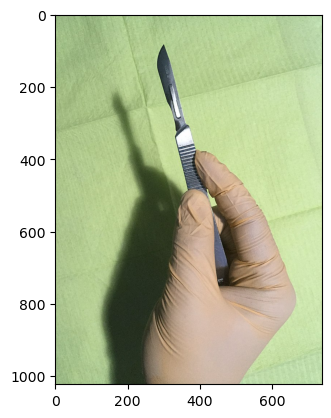

In [59]:
img = cv2.imread("C:\\Users\gmita\\Desktop\\work_3_2_2565\\onboard\\Surgical-Dataset\\cabodebisturn3-2-1.jpg",cv2.COLOR_BGR2RGB)
plt.imshow(img)

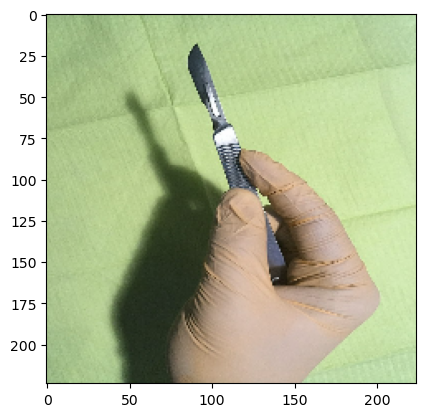

In [60]:
import numpy as np
a = cv2.resize(img, (224,224))
plt.imshow(a)
test = np.expand_dims(a,0)
test = test.astype('float32') / 255.0

In [61]:
preds = model2.predict(test)
predicted_class = np.argmax(preds, axis=1)[0]
print(predicted_class)

1/1 [==============================] - 1s 732ms/step
1


In [62]:
print(class_names)

['Curved Mayo Scissor', 'Scalpel', 'Straight Dissection Clamp', 'Straight Mayo Scissor']


In [63]:
preds = resnet50_model.predict(test)
predicted_class = np.argmax(preds, axis=1)[0]
print(predicted_class)

1/1 [==============================] - 1s 1s/step
3
